## These models predict deltaI, deltaR, and the scale factor using training data created with the MATLAB code HexagonSpec_TrainingData_PS. 


In [1]:
#Load packages
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import *

from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  



## This function will plot the true vs. predicted with various line fits
def plotSummary(true, predicted, name):
    #from pylab import *
    #import numpy as np
    #import matplotlib.pyplot as plt
    
    figure()
    plt.scatter(true,predicted, alpha = 0.2)
    
    plt.title(name)
    plt.xlabel('True')
    plt.ylabel('Predicted')

    xmin, xmax = plt.xlim()
    plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one

    fit_temp = np.polyfit(true, predicted,1)
    xp = np.linspace(xmin, xmax, 100)
    p = np.poly1d(fit_temp)
    plt.plot(xp, p(xp), '-', color = 'black')
    
    print(' ')
    print('RMSE on test data:', np.sqrt(mean_squared_error(true, predicted)), 'for ', name)
    print('R^2 Score on test data:', r2_score(true, predicted), 'for', name)

    
    return

def myResiduals(testY, predictY):
    ## residuals 1
    i = 0 # resetting i
    iterations = len(testY) # gets number of dots/points
    residual_sum = 0 # initializes sum of residuals
    for i in range (0,iterations): # for every dot/point
       ys = testY # get ys of testing data
       ys = ys.values # take out indexing, data types, names
       y = ys[i]
       predict_ys = predictY.values # get ys of all dots/points
       predict_y = predict_ys[i] # get the y value of the dot/point at specfic x value i
       diff = y - predict_y # find the difference in height
       diff = abs(diff) # take the absolute value
       residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals
    residual_average = residual_sum/iterations # find the average of the residuals
    print('The average residual for predict:', round(residual_average,4)) # display average of residuals

    minY = min(ys) # find the minimum y value for testing data
    maxY = max(ys) # find the max y value for testing data
    minpredict = min(predictY) # find the min y value for the prediction data
    maxpredict = max(predictY) # find the max y value for the prediction data
    #print('minY', minY, 'maxY', maxY)
    #print('minpredict', minpredict, 'maxpredict', maxpredict)
    rangeY = minY + maxY # find the range of the testing data
    rangepredict = minpredict - maxpredict # find the range of the predictions
    #print('rangeY', rangeY)
    #print('rangepredict', rangepredict)
    residual_percent_rangepredict = (residual_average/abs(rangepredict))*100 # calculate what percent the residual is of the range
    print('Residual is this percent of predict range', round(residual_percent_rangepredict,3), '%')
    
    return

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [2]:
# Creating Column Names 

energy = (pd.read_csv('HexagonBias_v4.csv', header=None)*1000).round().astype(int)
energy_names = ['E_%i_mV' % item for item in list(energy.T[0])]

col_names = ['deltaI', 'deltaR'] + energy_names # this would be used if we didn't want the scale factor 

# Loading Training Data 
# Spec Points
data = pd.read_csv('HexagonTrainingData180806_PS_sf_0.91_specPoints.csv', header = None, names = col_names)

# Making combination data peak info + spec points  
X = data.drop(['deltaI', 'deltaR'], axis = 1)
Y = data[['deltaI', 'deltaR']]

In [3]:
# Splitting Training and Testing Data 
ts1 = 0.3
rs1 = 42

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = ts1, random_state = rs1)

In [4]:
# Checking Combination Data
data.shape


(12000, 453)

In [5]:
# Checking Combination Data 
X.head()

,E_-400_mV,E_-398_mV,E_-396_mV,E_-394_mV,E_-392_mV,E_-390_mV,E_-388_mV,E_-386_mV,E_-384_mV,E_-382_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.170810,0.157490,0.148280,0.142180,0.138550,0.136780,0.136870,0.138570,0.141930,0.146900,...,1.6031,1.5842,1.5593,1.5284,1.4934,1.45480,1.41400,1.37210,1.32930,1.28750
1,0.133430,0.123110,0.116000,0.111350,0.108650,0.107380,0.107590,0.109070,0.111890,0.115980,...,1.8295,1.7879,1.7366,1.6770,1.6128,1.54520,1.47680,1.40930,1.34340,1.28120
2,0.067305,0.062575,0.059428,0.057455,0.056496,0.056216,0.056757,0.057929,0.059932,0.062589,...,1.5216,1.3706,1.2394,1.1253,1.0287,0.94455,0.87313,0.81182,0.75896,0.71429
3,0.111580,0.102490,0.096165,0.092033,0.089545,0.088225,0.088143,0.089128,0.091153,0.094226,...,2.1412,2.1412,2.1172,2.0696,2.0030,1.92170,1.83020,1.73400,1.63560,1.53980
4,0.121910,0.112340,0.105730,0.101420,0.098892,0.097660,0.097786,0.099074,0.101560,0.105210,...,1.9731,1.9314,1.8756,1.8076,1.7323,1.65170,1.56950,1.48830,1.40890,1.33410


# Using the Best Models on the Hexagon Data 

## Decision Tree

### spec points

 
RMSE on test data: 0.010314946336514691 for  deltaI Depth 60
R^2 Score on test data: 0.9986970076376601 for deltaI Depth 60
 
RMSE on test data: 0.010461692482978395 for  deltaR Depth 60
R^2 Score on test data: 0.9994708286837112 for deltaR Depth 60


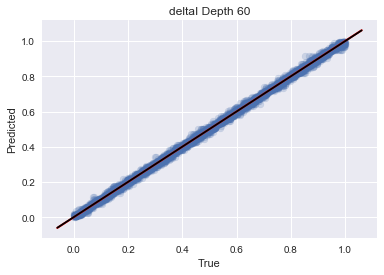

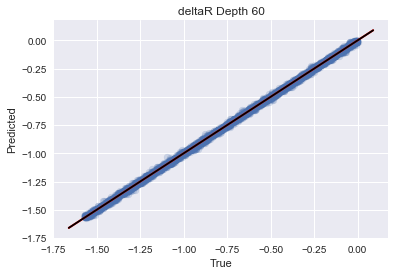

In [6]:
#Initialize the model
rs = 42
regr_DT_sp = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
regr_DT_sp = regr_DT_sp.fit(X_train, Y_train)

#print(data1[data1['Regr - DT']>0.001]) # feature importances 

#Use model to predict
predictions_DT_sp = regr_DT_sp.predict(X_test)

#Plot results
plotSummary(Y_test['deltaI'], predictions_DT_sp[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y_test['deltaR'], predictions_DT_sp[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])
# plotSummary(Y1_test['scale factor'], predictions_DT_sp[:,2], 'scale factor Depth 60')
#myResiduals(Y_test['scale factor'], y_3[:,2])

In [7]:
# spec info decision tree feature importances 
FI_sp_DT = pd.DataFrame(regr_DT_sp.feature_importances_.T, columns = ['Spec - DT'])
FI_sp_DT.index = X1_train.columns

#print(FI_sp_DT[FI_sp_DT['Spec - DT']>0.001])
features_sp_DT = (FI_sp_DT[FI_sp_DT['Spec - DT']>0.006])
features_sp_DT_sorted = features_sp_DT.sort_values('Spec - DT', ascending = False)

NameError: name 'X1_train' is not defined

## Random Forest

### spec points

 
RMSE on test data: 0.0033280656872496286 for  deltaI RF spec
R^2 Score on test data: 0.9998643587750005 for deltaI RF spec
 
RMSE on test data: 0.00334761488309682 for  deltaR RF spec
R^2 Score on test data: 0.9999458169590829 for deltaR RF spec


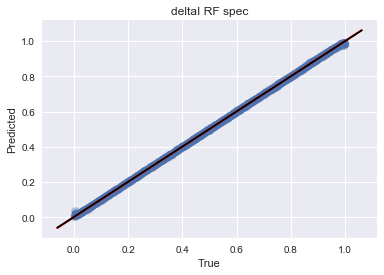

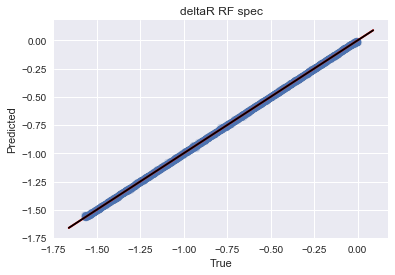

In [19]:
rs = 42
regr_RF_sp = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

model_RF_sp = regr_RF_sp.fit(X1_train, Y1_train)

predictions_RF_sp = model_RF_sp.predict(X1_test)

plotSummary(Y1_test['deltaI'], predictions_RF_sp[:,0], 'deltaI RF spec')
plotSummary(Y1_test['deltaR'], predictions_RF_sp[:,1], 'deltaR RF spec')
#plotSummary(Y1_test['scale factor'], predictions_RF_sp[:,2], 'scale factor RF spec')

In [20]:
# spec info random forest feature importances 
FI_sp_RF = pd.DataFrame(regr_RF_sp.feature_importances_.T, columns = ['Spec - RF'])
FI_sp_RF.index = X1_train.columns

#print(FI_sp_RF[FI_sp_RF['Spec - RF']>0.001])
features_sp_RF = (FI_sp_RF[FI_sp_RF['Spec - RF']>0.006])
features_sp_RF_sorted = features_sp_RF.sort_values('Spec - RF', ascending = False)

## Independent Random Forests

### spec points


Score - Random Forest: 0.9999810182608464 for deltaR IRF
 
RMSE on test data: 0.0019813983768199998 for  deltaR 10
R^2 Score on test data: 0.9999810182608464 for deltaR 10
 
RMSE on test data: 0.0024422908865204206 for  deltaI 10
R^2 Score on test data: 0.9999269529465786 for deltaI 10


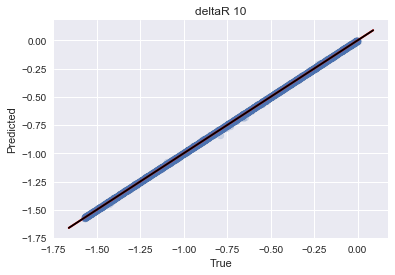

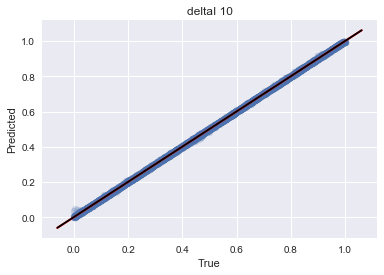

In [26]:
#Trying Independent Random Forest

rs = 42
md = 30
n = 30

regr_RF2_dr_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
regr_RF2_di_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
#regr_RF2_sf_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

model_RF2_dr_sp = regr_RF2_dr_sp.fit(X1_train, Y1_train['deltaR'])
model_RF2_di_sp = regr_RF2_di_sp.fit(X1_train, Y1_train['deltaI'])
#model_RF2_sf_sp = regr_RF2_sf_sp.fit(X1_train, Y1_train['scale factor'])

predictions_RF2_dr_sp = model_RF2_dr_sp.predict(X1_test)
predictions_RF2_di_sp = model_RF2_di_sp.predict(X1_test)
#predictions_RF2_sf_sp = model_RF2_sf_sp.predict(X1_test)

#importance_RF_10 = pd.Series(model_RF2.feature_importances_, index = X_train.columns)

print('')
print('Score - Random Forest:' , model_RF2_dr_sp.score(X1_test, Y1_test['deltaR']), 'for deltaR IRF')

plotSummary(Y1_test['deltaR'], predictions_RF2_dr_sp, 'deltaR 10')
plotSummary(Y1_test['deltaI'], predictions_RF2_di_sp, 'deltaI 10')
#plotSummary(Y1_test['scale factor'], predictions_RF2_sf_sp, 'scale factor IRF')

In [27]:
# spec info independent random forest feature importances delta R  
FI_sp_RF2_dr = pd.DataFrame(model_RF2_dr_sp.feature_importances_.T, columns = ['Spec - RF2_dr'])
FI_sp_RF2_dr.index = X1_train.columns

# print(FI_sp_RF2_dr[FI_sp_RF2_dr['Spec - RF2_dr']>0.001])
features_sp_RF2_dr = (FI_sp_RF2_dr[FI_sp_RF2_dr['Spec - RF2_dr']>0.006])
features_sp_RF2_dr_sorted = features_sp_RF2_dr.sort_values('Spec - RF2_dr', ascending = False)

# spec info independent random forest feature importances delta I  
FI_sp_RF2_di = pd.DataFrame(model_RF2_di_sp.feature_importances_.T, columns = ['Spec - RF2_di'])
FI_sp_RF2_di.index = X1_train.columns

# print(FI_sp_RF2_di[FI_sp_RF2_di['Spec - RF2_di']>0.001])
features_sp_RF2_di = (FI_sp_RF2_di[FI_sp_RF2_di['Spec - RF2_di']>0.006])
features_sp_RF2_di_sorted = features_sp_RF2_di.sort_values('Spec - RF2_di', ascending = False)

# spec info independent random forest feature importances scale factor 
#FI_sp_RF2_sf = pd.DataFrame(model_RF2_sf_sp.feature_importances_.T, columns = ['Spec - RF2_sf'])
#FI_sp_RF2_sf.index = X1_train.columns

# print(FI_sp_RF2_sf[FI_sp_RF2_sf['Spec - RF2_sf']>0.001])
#features_sp_RF2_sf = (FI_sp_RF2_sf[FI_sp_RF2_sf['Spec - RF2_sf']>0.006])
#features_sp_RF2_sf_sorted = features_sp_RF2_sf.sort_values('Spec - RF2_sf', ascending = False)

## AdaBoost Random Forest

### spec points

 
RMSE on test data: 0.0030931607676152884 for  AdaBoost Delta I SP
R^2 Score on test data: 0.9998828309495139 for AdaBoost Delta I SP
 
RMSE on test data: 0.002193947083370641 for  AdaBoost Delta R SP
R^2 Score on test data: 0.9999767274114091 for AdaBoost Delta R SP
Delta I AdaBoost Score: 0.9998828309495139
Delta R AdaBoost Score: 0.9999767274114091


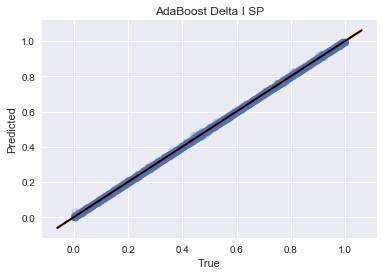

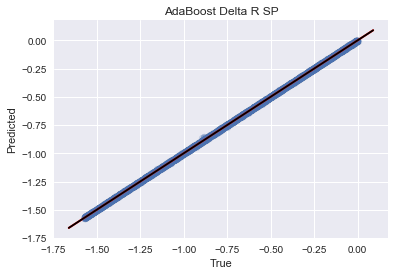

In [33]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

regr_AB_di_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
regr_AB_dr_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)
#regr_AB_sf_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

model_AB_di_sp = regr_AB_di_sp.fit(X1_train, Y1_train['deltaI'])
model_AB_dr_sp = regr_AB_dr_sp.fit(X1_train, Y1_train['deltaR'])
#model_AB_sf_sp = regr_AB_sf_sp.fit(X1_train, Y1_train['scale factor'])

predictions_AB_di_sp = model_AB_di_sp.predict(X1_test)
predictions_AB_dr_sp = model_AB_dr_sp.predict(X1_test)
#predictions_AB_sf_sp = model_AB_sf_sp.predict(X1_test)


plotSummary(Y1_test['deltaI'], predictions_AB_di_sp, 'AdaBoost Delta I SP')
plotSummary(Y1_test['deltaR'], predictions_AB_dr_sp, 'AdaBoost Delta R SP')
#plotSummary(Y1_test['scale factor'], predictions_AB_sf_sp, 'AdaBoost Scale Factor SP')

print('Delta I AdaBoost Score:', model_AB_di_sp.score(X1_test, Y1_test['deltaI']))
print('Delta R AdaBoost Score:', model_AB_dr_sp.score(X1_test, Y1_test['deltaR']))
#print('Scale Factor AdaBoost Score:', model_AB_sf_sp.score(X1_test, Y1_test['scale factor']))


In [34]:
# spec info adaboost random forest feature importances delta R  
FI_sp_AB_dr = pd.DataFrame(model_AB_dr_sp.feature_importances_.T, columns = ['Spec - AB_dr'])
FI_sp_AB_dr.index = X1_train.columns

# print(FI_sp_AB_dr[FI_sp_AB_dr['Spec - AB_dr']>0.001])
features_sp_AB_dr = (FI_sp_AB_dr[FI_sp_AB_dr['Spec - AB_dr']>0.006])
features_sp_AB_dr_sorted = features_sp_AB_dr.sort_values('Spec - AB_dr', ascending = False)

# spec info adaboost random forest feature importances delta I  
FI_sp_AB_di = pd.DataFrame(model_AB_di_sp.feature_importances_.T, columns = ['Spec - AB_di'])
FI_sp_AB_di.index = X1_train.columns

# print(FI_sp_AB_di[FI_sp_AB_di['Spec - AB_di']>0.001])
features_sp_AB_di = (FI_sp_AB_di[FI_sp_AB_di['Spec - AB_di']>0.006])
features_sp_AB_di_sorted = features_sp_AB_di.sort_values('Spec - AB_di', ascending = False)

# spec info adaboost random forest feature importances scale factor 
#FI_sp_AB_sf = pd.DataFrame(model_AB_sf_sp.feature_importances_.T, columns = ['Spec - AB_sf'])
#FI_sp_AB_sf.index = X1_train.columns

# print(FI_sp_AB_sf[FI_sp_AB_sf['Spec - AB_sf']>0.001])
#features_sp_AB_sf = (FI_sp_AB_sf[FI_sp_AB_sf['Spec - AB_sf']>0.006])
#features_sp_AB_sf_sorted = features_sp_AB_sf.sort_values('Spec - AB_sf', ascending = False)

### peak info

 
RMSE on test data: 0.013872890199210581 for  AdaBoost Delta I PI
R^2 Score on test data: 0.9976430963870512 for AdaBoost Delta I PI
 
RMSE on test data: 0.012780042542578448 for  AdaBoost Delta R PI
R^2 Score on test data: 0.9992103093529897 for AdaBoost Delta R PI


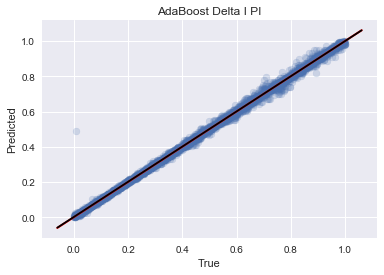

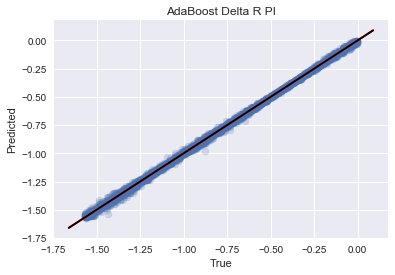

In [35]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

regr_AB_di_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
regr_AB_dr_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)
#regr_AB_sf_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

model_AB_di_pi = regr_AB_di_pi.fit(X2_train, Y2_train['deltaI'])
model_AB_dr_pi = regr_AB_dr_pi.fit(X2_train, Y2_train['deltaR'])
#model_AB_sf_pi = regr_AB_sf_pi.fit(X2_train, Y2_train['scale factor'])

predictions_AB_di_pi = model_AB_di_pi.predict(X2_test)
predictions_AB_dr_pi = model_AB_dr_pi.predict(X2_test)
#predictions_AB_sf_pi = model_AB_sf_pi.predict(X2_test)

plotSummary(Y2_test['deltaI'], predictions_AB_di_pi, 'AdaBoost Delta I PI')
plotSummary(Y2_test['deltaR'], predictions_AB_dr_pi, 'AdaBoost Delta R PI')
#plotSummary(Y2_test['scale factor'], predictions_AB_sf_pi, 'AdaBoost Scale Factor PI')

In [36]:
# peak info adaboost random forest feature importances delta R  
FI_pi_AB_dr = pd.DataFrame(model_AB_dr_pi.feature_importances_.T, columns = ['Peak - AB_dr'])
FI_pi_AB_dr.index = X2_train.columns

# print(FI_pi_AB_dr[FI_pi_AB_dr['Peak - AB_dr']>0.001])
features_pi_AB_dr = (FI_pi_AB_dr[FI_pi_AB_dr['Peak - AB_dr']>0.006])
features_pi_AB_dr_sorted = features_pi_AB_dr.sort_values('Peak - AB_dr', ascending = False)


# peak info adaboost random forest feature importances delta I 
FI_pi_AB_di = pd.DataFrame(model_AB_di_pi.feature_importances_.T, columns = ['Peak - AB_di'])
FI_pi_AB_di.index = X2_train.columns

# print(FI_pi_AB_di[FI_pi_AB_di['Peak - AB_di']>0.001])
features_pi_AB_di = (FI_pi_AB_di[FI_pi_AB_di['Peak - AB_di']>0.006])
features_pi_AB_di_sorted = features_pi_AB_di.sort_values('Peak - AB_di', ascending = False)

# peak info adaboost random forest feature importances scale factor
#FI_pi_AB_sf = pd.DataFrame(model_AB_sf_pi.feature_importances_.T, columns = ['Peak - AB_sf'])
#FI_pi_AB_sf.index = X2_train.columns

# print(FI_pi_AB_sf[FI_pi_AB_sf['Peak - AB_sf']>0.001])
#features_pi_AB_sf = (FI_pi_AB_sf[FI_pi_AB_sf['Peak - AB_sf']>0.006])
#features_pi_AB_sf_sorted = features_pi_AB_sf.sort_values('Peak - AB_sf', ascending = False)


### spec points and peak info

 
RMSE on test data: 0.002827091260004662 for  AdaBoost Delta I Combo
R^2 Score on test data: 0.9999021214380048 for AdaBoost Delta I Combo
 
RMSE on test data: 0.0022185219607959014 for  AdaBoost Delta R Combo
R^2 Score on test data: 0.99997620312883 for AdaBoost Delta R Combo


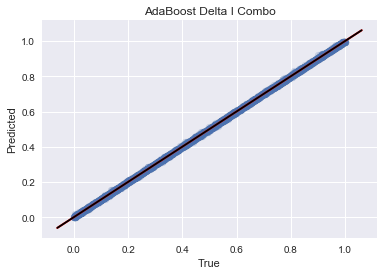

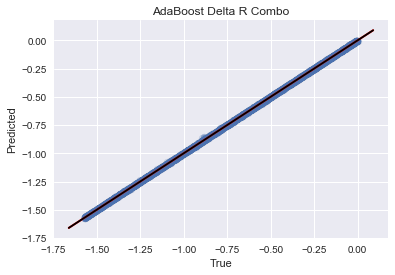

In [37]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

regr_AB_di_both = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
regr_AB_dr_both = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)
#regr_AB_sf_both = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

model_AB_di_both = regr_AB_di_both.fit(X_train, Y_train['deltaI'])
model_AB_dr_both = regr_AB_dr_both.fit(X_train, Y_train['deltaR'])
#model_AB_sf_both = regr_AB_sf_both.fit(X_train, Y_train['scale factor'])

predictions_AB_di_both = model_AB_di_both.predict(X_test)
predictions_AB_dr_both = model_AB_dr_both.predict(X_test)
#predictions_AB_sf_both = model_AB_sf_both.predict(X_test)

plotSummary(Y_test['deltaI'], predictions_AB_di_both, 'AdaBoost Delta I Combo')
plotSummary(Y_test['deltaR'], predictions_AB_dr_both, 'AdaBoost Delta R Combo')
#plotSummary(Y_test['scale factor'], predictions_AB_sf_both, 'AdaBoost Scale Factor Combo')

In [38]:
# combined info adaboost random forest feature importances delta R  
FI_b_AB_dr = pd.DataFrame(model_AB_dr_both.feature_importances_.T, columns = ['Both - AB_dr'])
FI_b_AB_dr.index = X_train.columns

# print(FI_b_AB_dr[FI_b_AB_dr['Both - AB_dr']>0.001])
features_b_AB_dr = (FI_b_AB_dr[FI_b_AB_dr['Both - AB_dr']>0.006])
features_b_AB_dr_sorted = features_b_AB_dr.sort_values('Both - AB_dr', ascending = False)


# combined info adaboost random forest feature importances delta I  
FI_b_AB_di = pd.DataFrame(model_AB_di_both.feature_importances_.T, columns = ['Both - AB_di'])
FI_b_AB_di.index = X_train.columns

# print(FI_b_AB_di[FI_b_AB_di['Both - AB_di']>0.001])
features_b_AB_di = (FI_b_AB_di[FI_b_AB_di['Both - AB_di']>0.006])
features_b_AB_di_sorted = features_b_AB_di.sort_values('Both - AB_di', ascending = False)

# combined info adaboost random forest feature importances scale factor 
#FI_b_AB_sf = pd.DataFrame(model_AB_sf_both.feature_importances_.T, columns = ['Both - AB_sf'])
#FI_b_AB_sf.index = X_train.columns

# print(FI_b_AB_sf[FI_b_AB_sf['Both - AB_sf']>0.001])
#features_b_AB_sf = (FI_b_AB_sf[FI_b_AB_sf['Both - AB_sf']>0.006])
#features_b_AB_sf_sorted = features_b_AB_sf.sort_values('Both - AB_sf', ascending = False)

In [39]:
display_side_by_side(features_sp_AB_dr_sorted, features_sp_AB_di_sorted, features_b_AB_dr_sorted, features_b_AB_di_sorted)
display_side_by_side(features_pi_AB_dr_sorted, features_pi_AB_di_sorted)

,Spec - AB_dr
E_-16_mV,0.413452
E_444_mV,0.192415
E_404_mV,0.063226
E_442_mV,0.059909
E_364_mV,0.048812
E_48_mV,0.041318
E_46_mV,0.029286
E_-200_mV,0.021112
E_406_mV,0.015384
E_44_mV,0.014396


,Peak - AB_dr
prom4,0.403722
loc4,0.230451
loc1,0.136699
peak4,0.132522
width4,0.028626
loc2,0.021710
loc3,0.015458
width1,0.010612
width3,0.007082
,Peak - AB_di


## Gradient Boosting Random Forest

### spec points

 
RMSE on test data: 0.013010759993107553 for  GradientBoost Delta I SP
R^2 Score on test data: 0.9979269333959698 for GradientBoost Delta I SP
 
RMSE on test data: 0.019475325925763946 for  GradientBoost Delta R SP
R^2 Score on test data: 0.9981661582146433 for GradientBoost Delta R SP


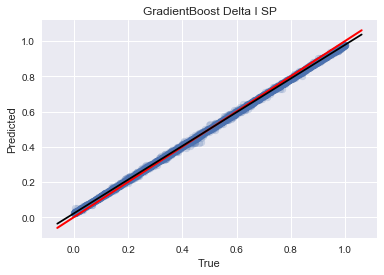

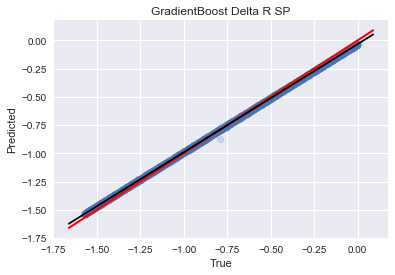

In [40]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30

regr_GB_di_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GB_dr_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
#regr_GB_sf_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)

model_GB_di_sp = regr_GB_di_sp.fit(X1_train, Y1_train['deltaI'])
model_GB_dr_sp = regr_GB_dr_sp.fit(X1_train, Y1_train['deltaR'])
#model_GB_sf_sp = regr_GB_sf_sp.fit(X1_train, Y1_train['scale factor'])

predictions_GB_di_sp = model_GB_di_sp.predict(X1_test)
predictions_GB_dr_sp = model_GB_dr_sp.predict(X1_test)
#predictions_GB_sf_sp = model_GB_sf_sp.predict(X1_test)

plotSummary(Y1_test['deltaI'], predictions_GB_di_sp, 'GradientBoost Delta I SP')
plotSummary(Y1_test['deltaR'], predictions_GB_dr_sp, 'GradientBoost Delta R SP')
#plotSummary(Y1_test['scale factor'], predictions_GB_sf_sp, 'GradientBoost Scale Factor SP')

In [41]:
# spec info gradientboost random forest feature importances delta R  
FI_sp_GB_dr = pd.DataFrame(model_GB_dr_sp.feature_importances_.T, columns = ['Spec - GB_dr'])
FI_sp_GB_dr.index = X1_train.columns

# print(FI_sp_GB_dr[FI_sp_GB_dr['Spec - GB_dr']>0.001])
features_sp_GB_dr = (FI_sp_GB_dr[FI_sp_GB_dr['Spec - GB_dr']>0.006])
features_sp_GB_dr_sorted = features_sp_GB_dr.sort_values('Spec - GB_dr', ascending = False)

# spec info gradientboost random forest feature importances delta I  
FI_sp_GB_di = pd.DataFrame(model_GB_di_sp.feature_importances_.T, columns = ['Spec - GB_di'])
FI_sp_GB_di.index = X1_train.columns

# print(FI_sp_GB_di[FI_sp_GB_di['Spec - GB_di']>0.001])
features_sp_GB_di = (FI_sp_GB_di[FI_sp_GB_di['Spec - GB_di']>0.006])
features_sp_GB_di_sorted = features_sp_GB_di.sort_values('Spec - GB_di', ascending = False)

# spec info gradientboost random forest feature importances scale factor   
#FI_sp_GB_sf = pd.DataFrame(model_GB_sf_sp.feature_importances_.T, columns = ['Spec - GB_sf'])
#FI_sp_GB_sf.index = X1_train.columns

# print(FI_sp_GB_sf[FI_sp_GB_sf['Spec - GB_sf']>0.001])
#features_sp_GB_sf = (FI_sp_GB_sf[FI_sp_GB_sf['Spec - GB_sf']>0.006])
#features_sp_GB_sf_sorted = features_sp_GB_sf.sort_values('Spec - GB_sf', ascending = False)

### peak info

 
RMSE on test data: 0.019156948050510228 for  GradientBoost Delta I PI
R^2 Score on test data: 0.9955057154340796 for GradientBoost Delta I PI
 
RMSE on test data: 0.023763545053692322 for  GradientBoost Delta R PI
R^2 Score on test data: 0.9972696718045616 for GradientBoost Delta R PI


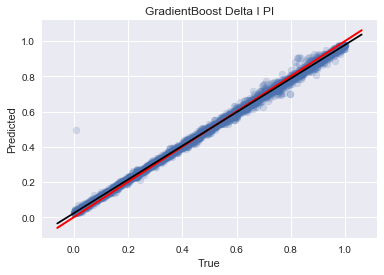

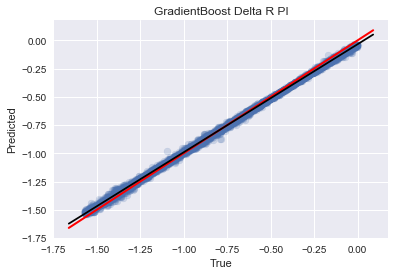

In [42]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30

regr_GB_di_pi = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GB_dr_pi = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
#regr_GB_sf_pi = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)

model_GB_di_pi = regr_GB_di_pi.fit(X2_train, Y2_train['deltaI'])
model_GB_dr_pi = regr_GB_dr_pi.fit(X2_train, Y2_train['deltaR'])
#model_GB_sf_pi = regr_GB_sf_pi.fit(X2_train, Y2_train['scale factor'])

predictions_GB_di_pi = model_GB_di_pi.predict(X2_test)
predictions_GB_dr_pi = model_GB_dr_pi.predict(X2_test)
#predictions_GB_sf_pi = model_GB_sf_pi.predict(X2_test)

plotSummary(Y2_test['deltaI'], predictions_GB_di_pi, 'GradientBoost Delta I PI')
plotSummary(Y2_test['deltaR'], predictions_GB_dr_pi, 'GradientBoost Delta R PI')
#plotSummary(Y2_test['scale factor'], predictions_GB_sf_pi, 'GradientBoost Scale Factor PI')

In [43]:
# peak info gradient boost random forest feature importances delta R  
FI_pi_GB_dr = pd.DataFrame(model_GB_dr_pi.feature_importances_.T, columns = ['Peak - GB_dr'])
FI_pi_GB_dr.index = X2_train.columns

# print(FI_pi_GB_dr[FI_pi_AB_dr['Peak - GB_dr']>0.001])
features_pi_GB_dr = (FI_pi_GB_dr[FI_pi_GB_dr['Peak - GB_dr']>0.006])
features_pi_GB_dr_sorted = features_pi_GB_dr.sort_values('Peak - GB_dr', ascending = False)


# peak info gradientboost random forest feature importances delta I 
FI_pi_GB_di = pd.DataFrame(model_GB_di_pi.feature_importances_.T, columns = ['Peak - GB_di'])
FI_pi_GB_di.index = X2_train.columns

# print(FI_pi_GB_di[FI_pi_GB_di['Peak - GB_di']>0.001])
features_pi_GB_di = (FI_pi_GB_di[FI_pi_GB_di['Peak - GB_di']>0.006])
features_pi_GB_di_sorted = features_pi_GB_di.sort_values('Peak - GB_di', ascending = False)


# peak info gradientboost random forest feature importances scale factor
#FI_pi_GB_sf = pd.DataFrame(model_GB_sf_pi.feature_importances_.T, columns = ['Peak - GB_sf'])
#FI_pi_GB_sf.index = X2_train.columns

# print(FI_pi_GB_sf[FI_pi_GB_sf['Peak - GB_sf']>0.001])
#features_pi_GB_sf = (FI_pi_GB_sf[FI_pi_GB_sf['Peak - GB_sf']>0.006])
#features_pi_GB_sf_sorted = features_pi_GB_sf.sort_values('Peak - GB_sf', ascending = False)

### spec points and peak info

 
RMSE on test data: 0.013059054872355964 for  GradientBoost Delta I Combo
R^2 Score on test data: 0.9979115147244668 for GradientBoost Delta I Combo
 
RMSE on test data: 0.019491487177465846 for  GradientBoost Delta R Combo
R^2 Score on test data: 0.9981631133900555 for GradientBoost Delta R Combo


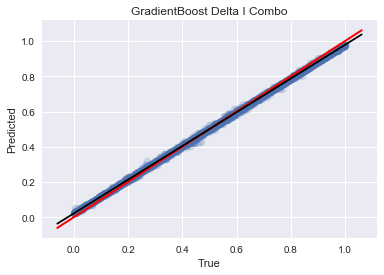

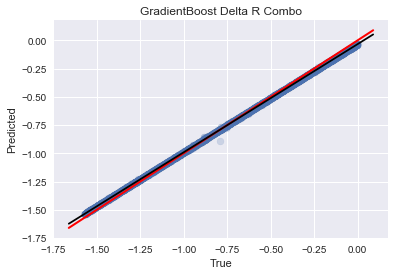

In [44]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30

regr_GB_di_both = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GB_dr_both = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
#regr_GB_sf_both = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)

model_GB_di_both = regr_GB_di_both.fit(X_train, Y_train['deltaI'])
model_GB_dr_both = regr_GB_dr_both.fit(X_train, Y_train['deltaR'])
#model_GB_sf_both = regr_GB_sf_both.fit(X_train, Y_train['scale factor'])

predictions_GB_di_both = model_GB_di_both.predict(X_test)
predictions_GB_dr_both = model_GB_dr_both.predict(X_test)
#predictions_GB_sf_both = model_GB_sf_both.predict(X_test)

plotSummary(Y_test['deltaI'], predictions_GB_di_both, 'GradientBoost Delta I Combo')
plotSummary(Y_test['deltaR'], predictions_GB_dr_both, 'GradientBoost Delta R Combo')
#plotSummary(Y_test['scale factor'], predictions_GB_sf_both, 'GradientBoost Scale Factor Combo')


In [45]:
# combined info gradient boost random forest feature importances delta R  
FI_b_GB_dr = pd.DataFrame(model_GB_dr_both.feature_importances_.T, columns = ['Both - GB_dr'])
FI_b_GB_dr.index = X_train.columns

# print(FI_b_GB_dr[FI_b_GB_dr['Both - GB_dr']>0.001])
features_b_GB_dr = (FI_b_GB_dr[FI_b_GB_dr['Both - GB_dr']>0.006])
features_b_GB_dr_sorted = features_b_GB_dr.sort_values('Both - GB_dr', ascending = False)


# combined info gradient boost random forest feature importances delta I  
FI_b_GB_di = pd.DataFrame(model_GB_di_both.feature_importances_.T, columns = ['Both - GB_di'])
FI_b_GB_di.index = X_train.columns

# print(FI_b_GB_di[FI_b_GB_di['Both - GB_di']>0.001])
features_b_GB_di = (FI_b_GB_di[FI_b_GB_di['Both - GB_di']>0.006])
features_b_GB_di_sorted = features_b_GB_di.sort_values('Both - GB_di', ascending = False)

# combined info gradient boost random forest feature importances scale factor 
#FI_b_GB_sf = pd.DataFrame(model_GB_sf_both.feature_importances_.T, columns = ['Both - GB_sf'])
#FI_b_GB_sf.index = X_train.columns

# print(FI_b_GB_sf[FI_b_GB_sf['Both - GB_sf']>0.001])
#features_b_GB_sf = (FI_b_GB_sf[FI_b_GB_sf['Both - GB_sf']>0.006])
#features_b_GB_sf_sorted = features_b_GB_sf.sort_values('Both - GB_sf', ascending = False)

In [46]:
#display_side_by_side(features_sp_GB_dr_sorted, features_sp_GB_di_sorted,features_sp_GB_sf_sorted, features_b_GB_dr_sorted, features_b_GB_di_sorted, features_b_GB_sf_sorted)
#display_side_by_side(features_pi_GB_dr_sorted, features_pi_GB_di_sorted, features_pi_GB_sf_sorted)
display_side_by_side(features_sp_GB_dr_sorted, features_sp_GB_di_sorted, features_b_GB_dr_sorted, features_b_GB_di_sorted)
display_side_by_side(features_pi_GB_dr_sorted, features_pi_GB_di_sorted)

,Spec - GB_dr
E_442_mV,0.751183
E_404_mV,0.097314
E_-162_mV,0.082200
E_116_mV,0.012235
E_276_mV,0.011356
E_-128_mV,0.010960
E_24_mV,0.010687
,Spec - GB_di
E_-330_mV,0.621280
E_408_mV,0.131617


,Peak - GB_dr
prom4,0.546025
loc4,0.215508
peak4,0.115371
loc2,0.052088
width4,0.049555
width1,0.007154
,Peak - GB_di
width1,0.500923
loc1,0.293636
width2,0.064865


In [47]:
display_side_by_side(features_sp_RF_sorted, features_sp_DT_sorted, features_sp_GB_dr_sorted,features_sp_AB_dr_sorted,features_sp_RF2_dr_sorted)

,Spec - RF
E_442_mV,0.250544
E_440_mV,0.143622
E_-16_mV,0.071512
E_-288_mV,0.068302
E_438_mV,0.053380
E_490_mV,0.036923
E_492_mV,0.036271
E_226_mV,0.020663
E_364_mV,0.017914
E_404_mV,0.012724


In [48]:
display_side_by_side(features_sp_RF_sorted, features_sp_DT_sorted, features_sp_GB_di_sorted,features_sp_AB_di_sorted,features_sp_RF2_di_sorted)

,Spec - RF
E_442_mV,0.250544
E_440_mV,0.143622
E_-16_mV,0.071512
E_-288_mV,0.068302
E_438_mV,0.053380
E_490_mV,0.036923
E_492_mV,0.036271
E_226_mV,0.020663
E_364_mV,0.017914
E_404_mV,0.012724


In [49]:
#display_side_by_side(features_sp_RF_sorted, features_sp_DT_sorted, features_sp_GB_sf_sorted,features_sp_AB_sf_sorted,features_sp_RF2_sf_sorted)

In [50]:
display_side_by_side(features_pi_RF_sorted, features_pi_DT_sorted, features_pi_GB_dr_sorted,features_pi_AB_dr_sorted,features_pi_RF2_dr_sorted)

,Peak - RF
prom4,0.284961
peak4,0.228328
loc4,0.192570
loc1,0.076323
prom1,0.058506
peak1,0.046991
loc2,0.024387
loc3,0.022839
width1,0.018144
width3,0.014646


In [51]:
display_side_by_side(features_pi_RF_sorted, features_pi_DT_sorted, features_pi_GB_di_sorted,features_pi_AB_di_sorted,features_pi_RF2_di_sorted)

,Peak - RF
prom4,0.284961
peak4,0.228328
loc4,0.192570
loc1,0.076323
prom1,0.058506
peak1,0.046991
loc2,0.024387
loc3,0.022839
width1,0.018144
width3,0.014646


In [52]:
#display_side_by_side(features_pi_RF_sorted, features_pi_DT_sorted, features_pi_GB_sf_sorted,features_pi_AB_sf_sorted,features_pi_RF2_sf_sorted)

In [53]:
display_side_by_side(features_b_RF_sorted, features_b_DT_sorted, features_b_GB_dr_sorted,features_b_AB_dr_sorted,features_b_RF2_dr_sorted)

,Both - RF
E_442_mV,0.250539
E_440_mV,0.143578
width1,0.072435
E_-16_mV,0.071517
E_438_mV,0.053360
E_490_mV,0.036744
E_492_mV,0.036336
E_-288_mV,0.019034
E_226_mV,0.018456
E_364_mV,0.017984


In [54]:
display_side_by_side(features_b_RF_sorted, features_b_DT_sorted, features_b_GB_di_sorted,features_b_AB_di_sorted,features_b_RF2_di_sorted)

,Both - RF
E_442_mV,0.250539
E_440_mV,0.143578
width1,0.072435
E_-16_mV,0.071517
E_438_mV,0.053360
E_490_mV,0.036744
E_492_mV,0.036336
E_-288_mV,0.019034
E_226_mV,0.018456
E_364_mV,0.017984


In [55]:
#display_side_by_side(features_b_RF_sorted, features_b_DT_sorted, features_b_GB_sf_sorted,features_b_AB_sf_sorted,features_b_RF2_sf_sorted)


## Testing the Models on the Experimental Data



In [56]:
# Load the experimental data
col_names3 = peak_names + locs_names + width_names + prom_names
col_names4 = energy_names
col_names_exp_both = col_names_both[2:]

exp_data_sp = pd.read_csv('Training_Data/Hexagon/HexagonExperimentalData180721_PS_sf_specPoints.csv', header = None, names = col_names4)
exp_data_pi = pd.read_csv('Training_Data/Hexagon/HexagonExperimentalData180721_PS_sf_peakinfo.csv', header = None, names = col_names3)

In [57]:
# energy_names = ['E_%i_mV' % item for item in list(energy.T[0])]
# col_names1a = energy_names[50:] # use for taking out first peak specs 
# exp_data_sp = exp_data_sp[col_names1a] # use for taking out first peak specs 
exp_data_sp

,E_-400_mV,E_-398_mV,E_-396_mV,E_-394_mV,E_-392_mV,E_-390_mV,E_-388_mV,E_-386_mV,E_-384_mV,E_-382_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.63853,0.63594,0.64731,0.65819,0.67897,0.708,0.7397,0.7855,0.84717,0.91786,...,1.0453,1.0284,0.99538,0.98221,0.97146,0.97284,0.98729,0.98385,0.98191,0.97779


In [58]:
## Use these if want to remove first peak info
# peak_names2 = ['peak2', 'peak3', 'peak4']
# prom_names2 = ['prom2', 'prom3', 'prom4']
# locs_names2 = ['loc2', 'loc3', 'loc4']
# width_names2 = ['width2', 'width3', 'width4']
# pi_names = peak_names2 + locs_names2 + width_names2 + prom_names2
# exp_data_pi = exp_data_pi[pi_names]
exp_data_pi

,peak1,peak2,peak3,peak4,loc1,loc2,loc3,loc4,width1,width2,width3,width4,prom1,prom2,prom3,prom4
0,1.7917,1.9262,1.8662,1.4495,-0.362,-0.242,-0.074,0.134,0.026521,0.032045,0.039422,0.04612,1.1543,1.2902,1.1855,0.57098


In [59]:
# Use these if want to remove first peak info 
#subset = 5 
#energy_names2 = energy_names[50:]
#exp_data_sp2 = exp_data_sp[energy_names2]
#exp_data_both = exp_data_pi.join(exp_data_sp2, how = 'left')
exp_data_both = exp_data_pi.join(exp_data_sp, how = 'left')
exp_data_both


,peak1,peak2,peak3,peak4,loc1,loc2,loc3,loc4,width1,width2,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,1.7917,1.9262,1.8662,1.4495,-0.362,-0.242,-0.074,0.134,0.026521,0.032045,...,1.0453,1.0284,0.99538,0.98221,0.97146,0.97284,0.98729,0.98385,0.98191,0.97779


In [60]:
pred_phase_DT_sp = np.append(regr_DT_sp.predict(exp_data_sp),
                             r2_score(Y1_test['deltaI'], predictions_DT_sp[:,0])).reshape(3,1).T
pred_phase_DT_sp = np.append(pred_phase_DT_sp, 
                             r2_score(Y1_test['deltaR'], predictions_DT_sp[:,1])).reshape(4,1).T
#pred_phase_DT_sp = np.append(pred_phase_DT_sp, 
                          #   r2_score(Y1_test['scale factor'], predictions_DT_sp[:,2])).reshape(6,1).T

pred_phase_DT_pi = np.append(regr_DT_pi.predict(exp_data_pi), 
                            r2_score(Y1_test['deltaI'], predictions_DT_pi[:,0])).reshape(3,1).T
pred_phase_DT_pi = np.append(pred_phase_DT_pi, 
                            r2_score(Y1_test['deltaR'], predictions_DT_pi[:,1])).reshape(4,1).T
#pred_phase_DT_pi = np.append(pred_phase_DT_pi, 
                            #r2_score(Y1_test['scale factor'], predictions_DT_pi[:,2])).reshape(6,1).T

pred_phase_DT_both = np.append(regr_DT_both.predict(exp_data_both), 
                            r2_score(Y_test['deltaI'], predictions_DT_both[:,0])).reshape(3,1).T
pred_phase_DT_both = np.append(pred_phase_DT_both, 
                            r2_score(Y_test['deltaR'], predictions_DT_both[:,1])).reshape(4,1).T
#pred_phase_DT_both = np.append(pred_phase_DT_both, 
                      #      r2_score(Y_test['scale factor'], predictions_DT_both[:,2])).reshape(6,1).T

In [61]:
pred_phase_RF_sp = regr_RF_sp.predict(exp_data_sp)
pred_phase_RF_pi = regr_RF_pi.predict(exp_data_pi)
pred_phase_RF_both = regr_RF_both.predict(exp_data_both)

pred_phase_AB_R_sp = model_AB_dr_sp.predict(exp_data_sp)
pred_phase_AB_I_sp = model_AB_di_sp.predict(exp_data_sp)
#pred_phase_AB_sf_sp = model_AB_sf_sp.predict(exp_data_sp)

pred_phase_AB_R_pi = model_AB_dr_pi.predict(exp_data_pi)
pred_phase_AB_I_pi = model_AB_di_pi.predict(exp_data_pi)
#pred_phase_AB_sf_pi = model_AB_sf_pi.predict(exp_data_pi)

pred_phase_AB_R_both = model_AB_dr_both.predict(exp_data_both)
pred_phase_AB_I_both = model_AB_di_both.predict(exp_data_both)
#pred_phase_AB_sf_both = model_AB_sf_both.predict(exp_data_both)

pred_phase_GB_di_sp = model_GB_di_sp.predict(exp_data_sp)
pred_phase_GB_dr_sp = model_GB_dr_sp.predict(exp_data_sp)
#pred_phase_GB_sf_sp = model_GB_sf_sp.predict(exp_data_sp)

pred_phase_GB_di_pi = model_GB_di_pi.predict(exp_data_pi)
pred_phase_GB_dr_pi = model_GB_dr_pi.predict(exp_data_pi)
#pred_phase_GB_sf_pi = model_GB_sf_pi.predict(exp_data_pi)

pred_phase_GB_di_both = model_GB_di_both.predict(exp_data_both)
pred_phase_GB_dr_both = model_GB_dr_both.predict(exp_data_both)
#pred_phase_GB_sf_both = model_GB_sf_both.predict(exp_data_both)

pred_phase_IRF_di_sp = model_RF2_di_sp.predict(exp_data_sp)
pred_phase_IRF_dr_sp = model_RF2_dr_sp.predict(exp_data_sp)
#pred_phase_IRF_sf_sp = model_RF2_sf_sp.predict(exp_data_sp)

pred_phase_IRF_di_pi = model_RF2_di_pi.predict(exp_data_pi)
pred_phase_IRF_dr_pi = model_RF2_dr_pi.predict(exp_data_pi)
#pred_phase_IRF_sf_pi = model_RF2_sf_pi.predict(exp_data_pi)

pred_phase_IRF_di_both = model_RF2_di_both.predict(exp_data_both)
pred_phase_IRF_dr_both = model_RF2_dr_both.predict(exp_data_both)
#pred_phase_IRF_sf_both = model_RF2_sf_both.predict(exp_data_both)


In [62]:
#predictedPhases = pd.DataFrame(pred_phase_DT_sp, columns = ['deltaI', 'deltaR', 'deltaI score', 'deltaR score', 'scale factor', 'scale factor score'], index = ['Decision Tree spec points'])
predictedPhases = pd.DataFrame(pred_phase_DT_sp, columns = ['deltaI', 'deltaR', 'deltaI score', 'deltaR score'], index = ['Decision Tree spec points'])


In [63]:
#new_test = pd.Series(pred_phase_DT_pi[0], index = ['deltaI', 'deltaR', 'scale factor', 'deltaI score', 'deltaR score', 'scale factor score'], name = 'Decision Tree peak info')
new_test = pd.Series(pred_phase_DT_pi[0], index = ['deltaI', 'deltaR', 'deltaI score', 'deltaR score'], name = 'Decision Tree peak info')
predictedPhases = predictedPhases.append(new_test)

In [64]:
#new_1 = pd.Series(pred_phase_DT_both[0], index = ['deltaI', 'deltaR', 'scale factor', 'deltaI score', 'deltaR score', 'scale factor score'], name = 'Decision Tree spec points and peak info')
new_1 = pd.Series(pred_phase_DT_both[0], index = ['deltaI', 'deltaR', 'deltaI score', 'deltaR score'], name = 'Decision Tree spec points and peak info')
predictedPhases = predictedPhases.append(new_1)

In [65]:
RF_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF_sp[:,0])
RF_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF_sp[:,1])
#RF_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF_sp[:,2])

RF_pi_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF_pi[:,0])
RF_pi_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF_pi[:,1])
#RF_pi_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF_pi[:,2])

RF_b_di_r2score = r2_score(Y_test['deltaI'], predictions_RF_both[:,0])
RF_b_dr_r2score = r2_score(Y_test['deltaR'], predictions_RF_both[:,1])
#RF_b_sf_r2score = r2_score(Y_test['scale factor'], predictions_RF_both[:,2])

In [66]:
#predictedPhases.loc['Random Forest spec points'] = (pred_phase_RF_sp[0,0], pred_phase_RF_sp[0,1], pred_phase_RF_sp[0,2], RF_sp_di_r2score, RF_sp_dr_r2score, RF_sp_sf_r2score)
#predictedPhases.loc['Random Forest peak info'] = (pred_phase_RF_pi[0,0], pred_phase_RF_pi[0,1], pred_phase_RF_pi[0,2], RF_pi_di_r2score, RF_pi_dr_r2score, RF_pi_sf_r2score )
#predictedPhases.loc['Random Forest spec points and peak info'] = (pred_phase_RF_both[0,0], pred_phase_RF_both[0,1], pred_phase_RF_both[0,2], RF_b_di_r2score, RF_b_dr_r2score, RF_b_sf_r2score)

predictedPhases.loc['Random Forest spec points'] = (pred_phase_RF_sp[0,0], pred_phase_RF_sp[0,1], RF_sp_di_r2score, RF_sp_dr_r2score)
predictedPhases.loc['Random Forest peak info'] = (pred_phase_RF_pi[0,0], pred_phase_RF_pi[0,1], RF_pi_di_r2score, RF_pi_dr_r2score )
predictedPhases.loc['Random Forest spec points and peak info'] = (pred_phase_RF_both[0,0], pred_phase_RF_both[0,1], RF_b_di_r2score, RF_b_dr_r2score)

In [67]:
AB_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_AB_di_sp)
AB_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_AB_dr_sp)
#AB_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_AB_sf_sp)

AB_pi_di_r2score = r2_score(Y1_test['deltaI'], predictions_AB_di_pi)
AB_pi_dr_r2score = r2_score(Y1_test['deltaR'], predictions_AB_dr_pi)
#AB_pi_sf_r2score = r2_score(Y1_test['scale factor'], predictions_AB_sf_pi)

AB_b_di_r2score = r2_score(Y1_test['deltaI'], predictions_AB_di_both)
AB_b_dr_r2score = r2_score(Y1_test['deltaR'], predictions_AB_dr_both)
#AB_b_sf_r2score = r2_score(Y1_test['scale factor'], predictions_AB_sf_both)

In [68]:
#predictedPhases.loc['AdaBoost spec points'] = (pred_phase_AB_I_sp[0], pred_phase_AB_R_sp[0], pred_phase_AB_sf_sp[0], AB_sp_di_r2score, AB_sp_dr_r2score, AB_sp_sf_r2score)
#predictedPhases.loc['AdaBoost peak info'] = (pred_phase_AB_I_pi[0], pred_phase_AB_R_pi[0], pred_phase_AB_sf_pi[0], AB_pi_di_r2score, AB_pi_dr_r2score, AB_pi_sf_r2score) 
#predictedPhases.loc['AdaBoost spec points and peak info'] = (pred_phase_AB_I_both[0], pred_phase_AB_R_both[0], pred_phase_AB_sf_both[0], AB_b_di_r2score, AB_b_dr_r2score, AB_b_sf_r2score)



predictedPhases.loc['AdaBoost spec points'] = (pred_phase_AB_I_sp[0], pred_phase_AB_R_sp[0],  AB_sp_di_r2score, AB_sp_dr_r2score)
predictedPhases.loc['AdaBoost peak info'] = (pred_phase_AB_I_pi[0], pred_phase_AB_R_pi[0], AB_pi_di_r2score, AB_pi_dr_r2score) 
predictedPhases.loc['AdaBoost spec points and peak info'] = (pred_phase_AB_I_both[0], pred_phase_AB_R_both[0],  AB_b_di_r2score, AB_b_dr_r2score)


In [69]:
GB_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_GB_di_sp)
GB_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_GB_dr_sp)
#GB_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_GB_sf_sp)

GB_pi_di_r2score = r2_score(Y1_test['deltaI'], predictions_GB_di_pi)
GB_pi_dr_r2score = r2_score(Y1_test['deltaR'], predictions_GB_dr_pi)
#GB_pi_sf_r2score = r2_score(Y1_test['scale factor'], predictions_GB_sf_pi)

GB_b_di_r2score = r2_score(Y1_test['deltaI'], predictions_GB_di_both)
GB_b_dr_r2score = r2_score(Y1_test['deltaR'], predictions_GB_dr_both)
#GB_b_sf_r2score = r2_score(Y1_test['scale factor'], predictions_GB_sf_both)

In [70]:
#predictedPhases.loc['Gradient Boosting spec points'] = (pred_phase_GB_di_sp[0], pred_phase_GB_dr_sp[0], pred_phase_GB_sf_sp[0], GB_sp_di_r2score, GB_sp_dr_r2score, GB_sp_sf_r2score)
#predictedPhases.loc['Gradient Boosting peak info'] = (pred_phase_GB_di_pi[0], pred_phase_GB_dr_pi[0], pred_phase_GB_sf_pi[0], GB_pi_di_r2score, GB_pi_dr_r2score, GB_pi_sf_r2score) 
#predictedPhases.loc['Gradient Boosting spec points and peak info'] = (pred_phase_GB_di_both[0], pred_phase_GB_dr_both[0], pred_phase_GB_sf_both[0], GB_b_di_r2score, GB_b_dr_r2score, GB_b_sf_r2score)


predictedPhases.loc['Gradient Boosting spec points'] = (pred_phase_GB_di_sp[0], pred_phase_GB_dr_sp[0], GB_sp_di_r2score, GB_sp_dr_r2score)
predictedPhases.loc['Gradient Boosting peak info'] = (pred_phase_GB_di_pi[0], pred_phase_GB_dr_pi[0],  GB_pi_di_r2score, GB_pi_dr_r2score) 
predictedPhases.loc['Gradient Boosting spec points and peak info'] = (pred_phase_GB_di_both[0], GB_b_di_r2score, GB_b_dr_r2score, GB_b_di_r2score)


In [71]:
IRF_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF2_di_sp)
IRF_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF2_dr_sp)
#IRF_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF2_sf_sp)

IRF_pi_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF2_di_pi)
IRF_pi_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF2_dr_pi)
#IRF_pi_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF2_sf_pi)

IRF_b_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF2_di_both)
IRF_b_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF2_dr_both)
#IRF_b_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF2_sf_both)

In [72]:
#predictedPhases.loc['Independent Random Forests spec points'] = (pred_phase_IRF_di_sp[0], pred_phase_IRF_dr_sp[0],  pred_phase_IRF_sf_sp[0], IRF_sp_di_r2score, IRF_sp_dr_r2score, IRF_sp_sf_r2score)
#predictedPhases.loc['Independent Random Forests peak info'] = (pred_phase_IRF_di_pi[0], pred_phase_IRF_dr_pi[0],  pred_phase_IRF_sf_pi[0], IRF_pi_di_r2score, IRF_pi_dr_r2score, IRF_pi_sf_r2score)
#predictedPhases.loc['Independent Random Forests spec points and peak info'] = (pred_phase_IRF_di_both[0], pred_phase_IRF_dr_both[0],  pred_phase_IRF_sf_both[0], IRF_b_di_r2score, IRF_b_dr_r2score, IRF_b_sf_r2score)


predictedPhases.loc['Independent Random Forests spec points'] = (pred_phase_IRF_di_sp[0], pred_phase_IRF_dr_sp[0], IRF_sp_di_r2score, IRF_sp_dr_r2score)
predictedPhases.loc['Independent Random Forests peak info'] = (pred_phase_IRF_di_pi[0], pred_phase_IRF_dr_pi[0],  IRF_pi_di_r2score, IRF_pi_dr_r2score)
predictedPhases.loc['Independent Random Forests spec points and peak info'] = (pred_phase_IRF_di_both[0], pred_phase_IRF_dr_both[0],   IRF_b_di_r2score, IRF_b_dr_r2score)

In [73]:
predictedPhases

,deltaI,deltaR,deltaI score,deltaR score
Decision Tree spec points,0.009015,-0.071768,0.998696,0.999471
Decision Tree peak info,0.015697,-0.154510,0.997901,0.997880
Decision Tree spec points and peak info,0.007704,-0.085542,0.998714,0.999458
Random Forest spec points,0.026127,-0.081401,0.999864,0.999946
Random Forest peak info,0.021144,-0.158352,0.998599,0.999184
Random Forest spec points and peak info,0.024210,-0.087063,0.999504,0.999941
AdaBoost spec points,0.002205,-0.033647,0.999883,0.999977
AdaBoost peak info,0.004584,-0.077738,0.997643,0.999210
AdaBoost spec points and peak info,0.006333,-0.033647,0.999902,0.999976
Gradient Boosting spec points,0.022835,-0.073835,0.997927,0.998166


In [82]:
# Sorting Predicted Phases Dataframe 
predictedPhases.sort_values(by=['deltaI score'])

,deltaI,deltaR,deltaI score,deltaR score
Gradient Boosting peak info,0.023284,-0.108199,0.995506,0.997270
AdaBoost peak info,0.004584,-0.077738,0.997643,0.999210
Independent Random Forests peak info,0.003008,-0.093004,0.997870,0.998994
Decision Tree peak info,0.015697,-0.154510,0.997901,0.997880
Gradient Boosting spec points,0.022835,-0.073835,0.997927,0.998166
Gradient Boosting spec points and peak info,0.022802,0.997912,0.998163,0.997912
Random Forest peak info,0.021144,-0.158352,0.998599,0.999184
Decision Tree spec points,0.009015,-0.071768,0.998696,0.999471
Decision Tree spec points and peak info,0.007704,-0.085542,0.998714,0.999458
Random Forest spec points and peak info,0.024210,-0.087063,0.999504,0.999941


In [75]:
# Predictions with 0.95 or lower scores excluded 
GoodPredictedDeltaI = predictedPhases
GoodPredictedDeltaR = predictedPhases
#GoodPredictedScaleFactor = predictedPhases.drop(['Decision Tree peak info', 'Decision Tree spec points', 'Decision Tree spec points and peak info', 'Random Forest peak info'], axis = 0)


deltaI_1 = (GoodPredictedDeltaI['deltaI']*GoodPredictedDeltaI['deltaI score']).mean()
deltaR_1 = (GoodPredictedDeltaR['deltaR']*GoodPredictedDeltaR['deltaR score']).mean()
#scale_factor1 = (GoodPredictedScaleFactor['scale factor']*GoodPredictedScaleFactor['scale factor score']).mean()
print('The weighted average for the predicted phase is: ', deltaR_1, ' + ', deltaI_1, '*i')
#print('The weighted average for the scale factor is:', scale_factor1)

The weighted average for the predicted phase is:  -0.009098879456736996  +  0.01291885852231403 *i


In [76]:
#predictedPhases[['deltaI', 'deltaR', 'scale factor']].to_csv('Model_Results/Hexagon/predictions_PS_sf_FI_180721.csv')
#predictedPhases[['deltaI score', 'deltaR score', 'scale factor score']].to_csv('Model_Results/Hexagon/scores_PS_sf_FI_180721.csv')

predictedPhases[['deltaI', 'deltaR']].to_csv('Model_Results/Hexagon/predictions_PS_FI_180727.csv')
predictedPhases[['deltaI score', 'deltaR score']].to_csv('Model_Results/Hexagon/scores_PS_FI_180727.csv')

In [77]:
importance_DT_ = pd.Series(regr_DT_both.feature_importances_, index = X_train.columns)
importance_DT_ = pd.Series(regr_DT_both.feature_importances_, index = X_train.columns)
importance_RF_= pd.Series(model_RF_both.feature_importances_, index = X_train.columns)
importance_IRF_r = pd.Series(model_RF2_dr_both.feature_importances_, index = X_train.columns)
importance_IRF_i = pd.Series(model_RF2_di_both.feature_importances_, index = X_train.columns)
#importance_IRF_sf = pd.Series(model_RF2_sf_both.feature_importances_, index = X_train.columns)
importance_ARF_r = pd.Series(model_AB_dr_both.feature_importances_, index = X_train.columns)
importance_ARF_i = pd.Series(model_AB_di_both.feature_importances_, index = X_train.columns)
#importance_ARF_sf = pd.Series(model_AB_sf_both.feature_importances_, index = X_train.columns)
importance_GRF_r = pd.Series(model_GB_dr_both.feature_importances_, index = X_train.columns)
importance_GRF_i = pd.Series(model_GB_di_both.feature_importances_, index = X_train.columns)
#importance_GRF_sf = pd.Series(model_GB_sf_both.feature_importances_, index = X_train.columns)

In [78]:
#tenFeatures = linspace(0,10, 10)
DT_FI_top = importance_DT_.nlargest(10)
RF_FI_top = importance_RF_.nlargest(10)
IRF_r_FI_top = importance_IRF_r.nlargest(10)
IRF_i_FI_top = importance_IRF_i.nlargest(10)
#IRF_sf_FI_top = importance_IRF_sf.nlargest(10)
ARF_r_FI_top = importance_ARF_r.nlargest(10)
ARF_i_FI_top = importance_ARF_i.nlargest(10)
#ARF_sf_FI_top = importance_ARF_sf.nlargest(10)
GRF_r_FI_top = importance_GRF_r.nlargest(10)
GRF_i_FI_top = importance_GRF_i.nlargest(10)
#GRF_sf_FI_top = importance_GRF_sf.nlargest(10)
tops_list = [DT_FI_top, RF_FI_top, IRF_r_FI_top,IRF_i_FI_top, ARF_r_FI_top, ARF_i_FI_top, GRF_r_FI_top, GRF_i_FI_top ]
tops = pd.concat(tops_list)
#tops.plot(kind = 'pie')
tops_count = tops.groupby(level=[0]).size()
tops_count.sort_values(axis = 0)
tops_count = tops_count.sort_values()
tops_count

E_-128_mV    1
E_48_mV      1
E_476_mV     1
E_46_mV      1
E_468_mV     1
E_446_mV     1
E_382_mV     1
E_378_mV     1
E_364_mV     1
E_320_mV     1
peak2        1
E_24_mV      1
E_226_mV     1
E_-388_mV    1
E_-332_mV    1
E_276_mV     1
width1       1
E_-136_mV    1
E_-160_mV    1
E_-326_mV    1
E_-322_mV    1
E_-314_mV    1
E_-220_mV    1
E_-212_mV    1
E_-200_mV    1
E_492_mV     2
E_490_mV     2
E_-162_mV    2
E_44_mV      2
E_-198_mV    2
E_444_mV     2
E_438_mV     2
E_-334_mV    2
E_376_mV     2
E_374_mV     2
E_-288_mV    2
E_116_mV     2
E_-400_mV    2
E_-398_mV    2
E_-328_mV    2
E_410_mV     2
E_42_mV      3
E_-330_mV    3
E_442_mV     3
E_404_mV     3
E_-16_mV     3
E_440_mV     4
E_408_mV     4
dtype: int64

In [79]:
#sf_tops_list = [IRF_sf_FI_top, ARF_sf_FI_top, GRF_sf_FI_top ]
#sf_tops = pd.concat(sf_tops_list)
#sf_tops.plot(kind = 'pie')
#sf_tops_count = sf_tops.groupby(level=[0]).size()
#sf_tops_count.sort_values(axis = 0)
#sf_tops_count = sf_tops_count.sort_values()
#sf_tops_count

Text(0,0.5,'Feature Importance')

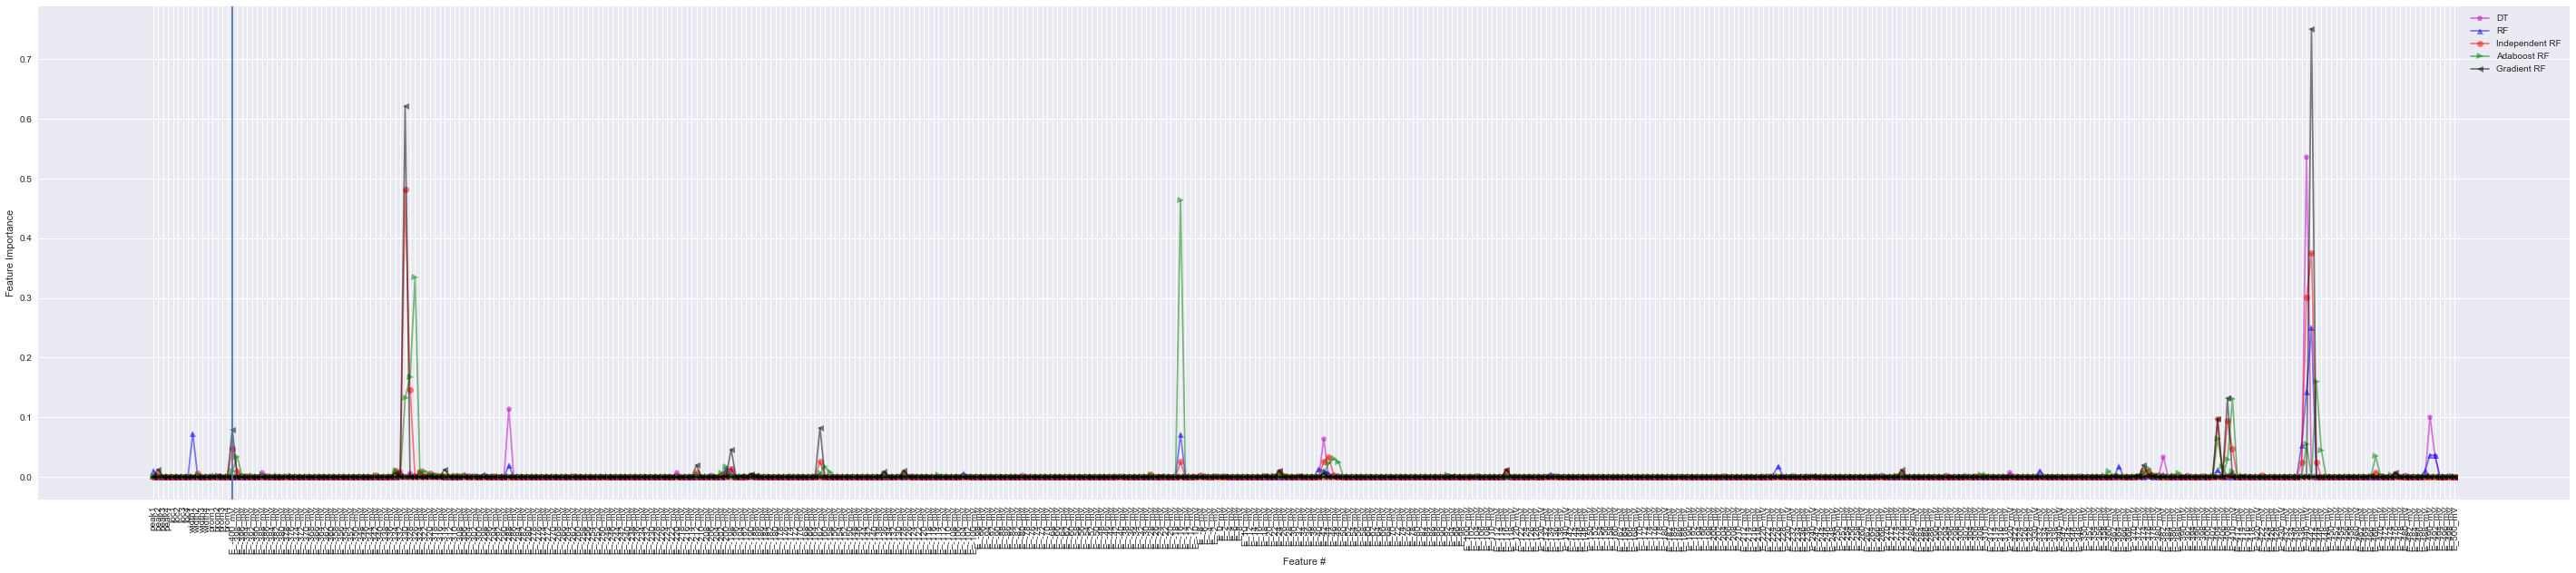

In [80]:
Features = linspace(0,467, 467)
figure(figsize=(50,10))
plt.plot(Features, importance_DT_, 'mp-', alpha = 0.5, label = "DT")
plt.plot(Features, importance_RF_, 'b^-', alpha = 0.5, label = "RF")
plt.plot(Features, importance_IRF_i,  'ro-', alpha = 0.5, label = "Independent RF")
plt.plot(Features, importance_IRF_r,  'ro-', alpha = 0.5)
plt.plot(Features, importance_ARF_i, 'g>-',alpha = 0.5, label = "Adaboost RF")
plt.plot(Features, importance_ARF_r, 'g>-',alpha = 0.5)
plt.plot(Features, importance_GRF_i, 'k<-', alpha = 0.5, label = "Gradient RF")
plt.plot(Features, importance_GRF_r, 'k<-', alpha = 0.5)
legend(loc = 'best')
plt.xticks(Features, col_names_exp_both, rotation = 'vertical')
matplotlib.pyplot.axvline(x=16, ymin=0, ymax=1)
xlabel('Feature #')
ylabel('Feature Importance')

(0, 50)

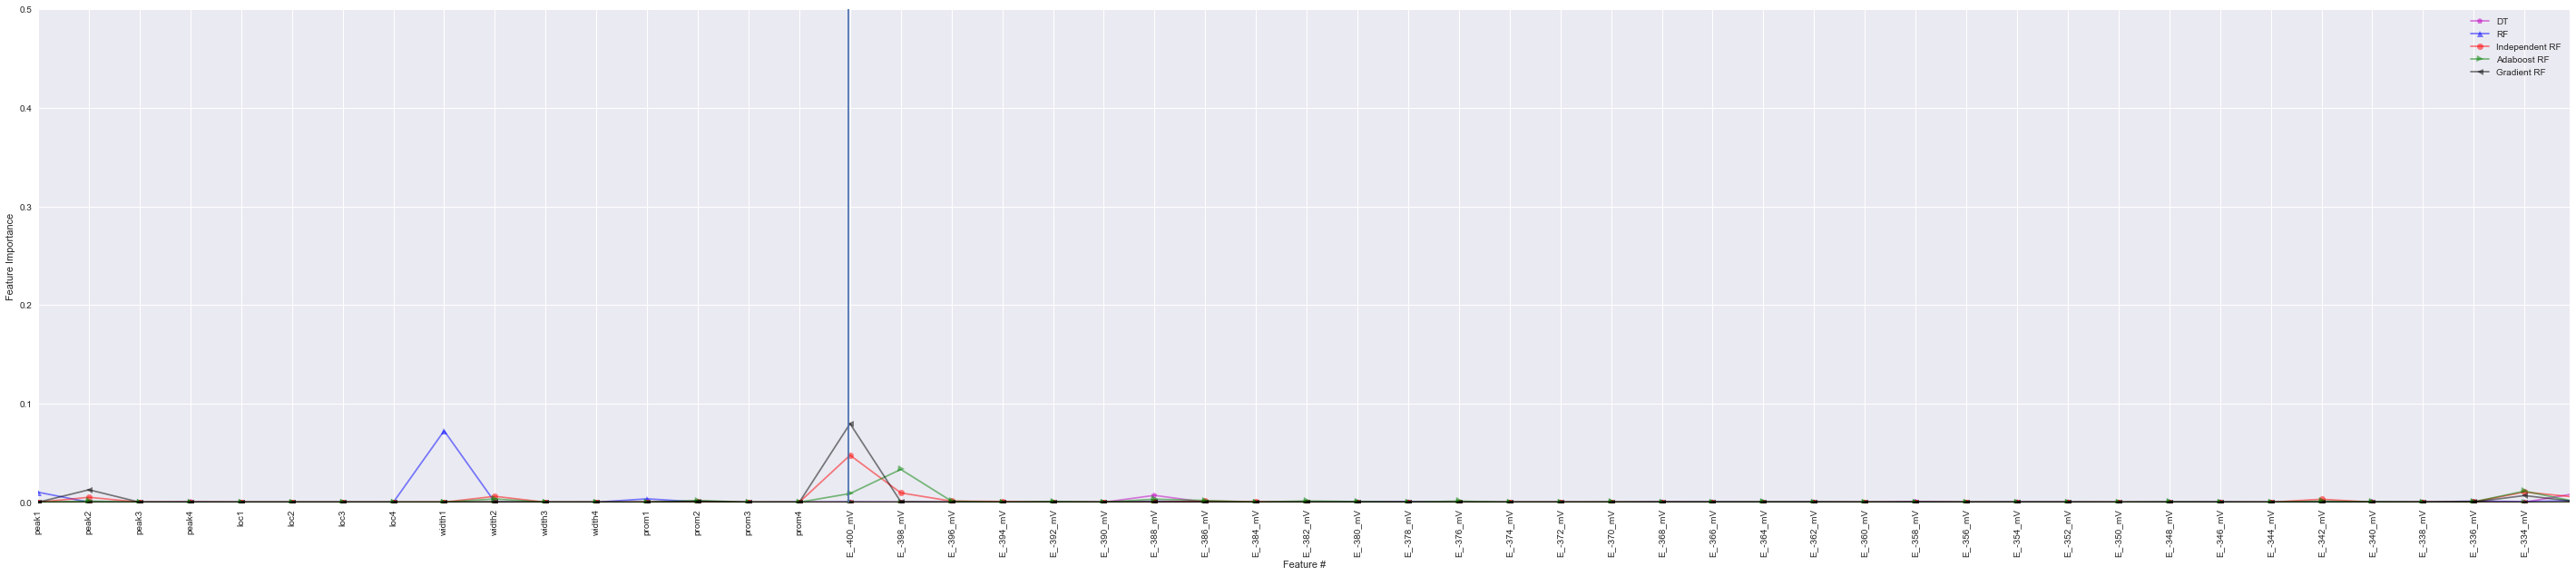

In [81]:
Features = linspace(0,467, 467)
figure(figsize=(50,10))
plt.plot(Features, importance_DT_, 'mp-', alpha = 0.5, label = "DT")
plt.plot(Features, importance_RF_, 'b^-', alpha = 0.5, label = "RF")
plt.plot(Features, importance_IRF_i,  'ro-', alpha = 0.5, label = "Independent RF")
plt.plot(Features, importance_IRF_r,  'ro-', alpha = 0.5)
plt.plot(Features, importance_ARF_i, 'g>-',alpha = 0.5, label = "Adaboost RF")
plt.plot(Features, importance_ARF_r, 'g>-',alpha = 0.5)
plt.plot(Features, importance_GRF_i, 'k<-', alpha = 0.5, label = "Gradient RF")
plt.plot(Features, importance_GRF_r, 'k<-', alpha = 0.5)
legend(loc = 'best')
plt.xticks(Features, col_names_exp_both, rotation = 'vertical')
matplotlib.pyplot.axvline(x=16, ymin=0, ymax=1)
xlabel('Feature #')
ylabel('Feature Importance')
ylim([0, 0.50])
xlim([0, 50])